
What Can Transformers Learn In-Context? A Case Study of Simple Function Classes

Shivam Garg*, Dimitris Tsipras*, Percy Liang, Gregory Valiant

Paper: http://arxiv.org/abs/2208.01066


https://github.com/dtsip/in-context-learning.git


#Prerequisites

tested on Python 3.10 with a T4 GPU

In [ ]:
%%capture
!pip install -q matplotlib==3.5.2 numpy==1.22.3 pandas==1.4.2 scikit-learn==1.0.2 seaborn==0.11.2 tqdm==4.64.0 transformers==4.17.0 wandb==0.12.11 xgboost==1.6.1 protobuf==3.20.1 torch==2.1.0+cu118

#Config


In [ ]:
class args_c():
    class wandb_c():
        def __init__(self):             # wandb
            self.project = "in-context-learning"
            self.name = "linear_regression_toy"
            self.entity = "your-entity"
            self.notes = ""
            self.log_every_steps = 100

    class model_c():
        def __init__(self):             # model
            self.family = "gpt2"
            self.n_embd = 256
            self.n_layer = 12
            self.n_head = 8
            # toy: n_dims = 5, n_positions = 11
            # full: n_dims = 20, n_positions = 101
            self.n_dims = 20
            self.n_positions = 101

    class training_c():
        class curriculum_c():
            class dims_c():
                def __init__(self):     # dims
                    self.start = 5
                    self.end = 20
                    self.inc = 1
                    self.interval = 2000

            class points_c():
                def __init__(self):     # points
                    self.start = 11
                    self.end = 41
                    self.inc = 2
                    self.interval = 2000

            def __init__(self):         # curriculum
                self.dims = self.dims_c()
                self.points = self.points_c()

        def __init__(self):             # training
            self.task = "complex_polynomial_regression"                 #  "linear_regression", "sparse_linear_regression", "linear_classification", "relu_2nn_regression", "decision_tree"
            self.data = "gaussian"
            self.task_kwargs = {"degree":7}
            self.num_tasks = None
            self.num_training_examples = None
            self.batch_size = 64
            self.learning_rate = .0001
            self.save_every_steps = 1000
            self.keep_every_steps = 100000
            self.train_steps = 5001
            self.resume_id = None

            self.curriculum = self.curriculum_c()

    def __init__(self):                 # args
        self.wandb = self.wandb_c()
        self.model = self.model_c()
        self.training = self.training_c()

        self.out_dir = "./models/test"
        self.test_run = False
        self.using_wandb = False

args = args_c()

#Model

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2Model, GPT2Config
from tqdm import tqdm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Lasso
import warnings
from sklearn import tree
import xgboost as xgb

In [ ]:
def build_model(conf):
    if conf.family == "gpt2":
        model = TransformerModel(
            n_dims=conf.n_dims,
            n_positions=conf.n_positions,
            n_embd=conf.n_embd,
            n_layer=conf.n_layer,
            n_head=conf.n_head,
        )
    else:
        raise NotImplementedError

    return model


def get_relevant_baselines(task_name):
    task_to_baselines = {
        "linear_regression": [
            (LeastSquaresModel, {}),
            (NNModel, {"n_neighbors": 3}),
            (AveragingModel, {}),
        ],
        "linear_classification": [
            (NNModel, {"n_neighbors": 3}),
            (AveragingModel, {}),
        ],
        "sparse_linear_regression": [
            (LeastSquaresModel, {}),
            (NNModel, {"n_neighbors": 3}),
            (AveragingModel, {}),
        ]
        + [(LassoModel, {"alpha": alpha}) for alpha in [1, 0.1, 0.01, 0.001, 0.0001]],
        "relu_2nn_regression": [
            (LeastSquaresModel, {}),
            (NNModel, {"n_neighbors": 3}),
            (AveragingModel, {}),
            (
                GDModel,
                {
                    "model_class": NeuralNetwork,
                    "model_class_args": {
                        "in_size": 20,
                        "hidden_size": 100,
                        "out_size": 1,
                    },
                    "opt_alg": "adam",
                    "batch_size": 100,
                    "lr": 5e-3,
                    "num_steps": 100,
                },
            ),
        ],
        "decision_tree": [
            (LeastSquaresModel, {}),
            (NNModel, {"n_neighbors": 3}),
            (DecisionTreeModel, {"max_depth": 4}),
            (DecisionTreeModel, {"max_depth": None}),
            (XGBoostModel, {}),
            (AveragingModel, {}),
        ],
        "single_degree_polynomial_regression": [
            (LeastSquaresModel, {}),
            (NNModel, {"n_neighbors": 3}),
            (DecisionTreeModel, {"max_depth": 4}),
            (DecisionTreeModel, {"max_depth": None}),
            (XGBoostModel, {}),
            (AveragingModel, {}),
        ],
        "complex_polynomial_regression": [
            (LeastSquaresModel, {}),
            (NNModel, {"n_neighbors": 3}),
            (DecisionTreeModel, {"max_depth": 4}),
            (DecisionTreeModel, {"max_depth": None}),
            (XGBoostModel, {}),
            (AveragingModel, {}),
        ]
    }

    models = [model_cls(**kwargs) for model_cls, kwargs in task_to_baselines[task_name]]
    return models


class NeuralNetwork(nn.Module):
    def __init__(self, in_size=50, hidden_size=1000, out_size=1):
        super(NeuralNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
        )

    def forward(self, x):
        out = self.net(x)
        return out


class ParallelNetworks(nn.Module):
    def __init__(self, num_models, model_class, **model_class_init_args):
        super(ParallelNetworks, self).__init__()
        self.nets = nn.ModuleList(
            [model_class(**model_class_init_args) for i in range(num_models)]
        )

    def forward(self, xs):
        assert xs.shape[0] == len(self.nets)

        for i in range(len(self.nets)):
            out = self.nets[i](xs[i])
            if i == 0:
                outs = torch.zeros(
                    [len(self.nets)] + list(out.shape), device=out.device
                )
            outs[i] = out
        return outs

class TransformerModel(nn.Module):
    def __init__(self, n_dims, n_positions, n_embd=128, n_layer=12, n_head=4):
        super(TransformerModel, self).__init__()
        configuration = GPT2Config(
            n_positions=2 * n_positions,
            n_embd=n_embd,
            n_layer=n_layer,
            n_head=n_head,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )
        self.name = f"gpt2_embd={n_embd}_layer={n_layer}_head={n_head}"

        self.n_positions = n_positions
        self.n_dims = n_dims
        self._read_in = nn.Linear(n_dims, n_embd)
        self._backbone = GPT2Model(configuration)
        self._read_out = nn.Linear(n_embd, 1)

    @staticmethod
    def _combine(xs_b, ys_b):
        """Interleaves the x's and the y's into a single sequence."""
        bsize, points, dim = xs_b.shape
        ys_b_wide = torch.cat(
            (
                ys_b.view(bsize, points, 1),
                torch.zeros(bsize, points, dim - 1, device=ys_b.device),
            ),
            axis=2,
        )
        zs = torch.stack((xs_b, ys_b_wide), dim=2)
        zs = zs.view(bsize, 2 * points, dim)
        return zs

    def forward(self, xs, ys, inds=None):
        if inds is None:
            inds = torch.arange(ys.shape[1])
        else:
            inds = torch.tensor(inds)
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")
        zs = self._combine(xs, ys)
        embeds = self._read_in(zs)
        output = self._backbone(inputs_embeds=embeds).last_hidden_state
        prediction = self._read_out(output)
        return prediction[:, ::2, 0][:, inds]  # predict only on xs


class NNModel:
    def __init__(self, n_neighbors, weights="uniform"):
        # should we be picking k optimally
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.name = f"NN_n={n_neighbors}_{weights}"

    def __call__(self, xs, ys, inds=None):
        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []

        for i in inds:
            if i == 0:
                preds.append(torch.zeros_like(ys[:, 0]))  # predict zero for first point
                continue
            train_xs, train_ys = xs[:, :i], ys[:, :i]
            test_x = xs[:, i : i + 1]
            dist = (train_xs - test_x).square().sum(dim=2).sqrt()

            if self.weights == "uniform":
                weights = torch.ones_like(dist)
            else:
                weights = 1.0 / dist
                inf_mask = torch.isinf(weights).float()  # deal with exact match
                inf_row = torch.any(inf_mask, axis=1)
                weights[inf_row] = inf_mask[inf_row]

            pred = []
            k = min(i, self.n_neighbors)
            ranks = dist.argsort()[:, :k]
            for y, w, n in zip(train_ys, weights, ranks):
                y, w = y[n], w[n]
                pred.append((w * y).sum() / w.sum())
            preds.append(torch.stack(pred))

        return torch.stack(preds, dim=1)


# xs and ys should be on cpu for this method. Otherwise the output maybe off in case when train_xs is not full rank due to the implementation of torch.linalg.lstsq.
class LeastSquaresModel:
    def __init__(self, driver=None):
        self.driver = driver
        self.name = f"OLS_driver={driver}"

    def __call__(self, xs, ys, inds=None):
        xs, ys = xs.cpu(), ys.cpu()
        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []

        for i in inds:
            if i == 0:
                preds.append(torch.zeros_like(ys[:, 0]))  # predict zero for first point
                continue
            train_xs, train_ys = xs[:, :i], ys[:, :i]
            test_x = xs[:, i : i + 1]

            ws, _, _, _ = torch.linalg.lstsq(
                train_xs, train_ys.unsqueeze(2), driver=self.driver
            )

            pred = test_x @ ws
            preds.append(pred[:, 0, 0])

        return torch.stack(preds, dim=1)


class AveragingModel:
    def __init__(self):
        self.name = "averaging"

    def __call__(self, xs, ys, inds=None):
        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []

        for i in inds:
            if i == 0:
                preds.append(torch.zeros_like(ys[:, 0]))  # predict zero for first point
                continue
            train_xs, train_ys = xs[:, :i], ys[:, :i]
            test_x = xs[:, i : i + 1]

            train_zs = train_xs * train_ys.unsqueeze(dim=-1)
            w_p = train_zs.mean(dim=1).unsqueeze(dim=-1)
            pred = test_x @ w_p
            preds.append(pred[:, 0, 0])

        return torch.stack(preds, dim=1)


# Lasso regression (for sparse linear regression).
# Seems to take more time as we decrease alpha.
class LassoModel:
    def __init__(self, alpha, max_iter=100000):
        # the l1 regularizer gets multiplied by alpha.
        self.alpha = alpha
        self.max_iter = max_iter
        self.name = f"lasso_alpha={alpha}_max_iter={max_iter}"

    # inds is a list containing indices where we want the prediction.
    # prediction made at all indices by default.
    def __call__(self, xs, ys, inds=None):
        xs, ys = xs.cpu(), ys.cpu()

        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []  # predict one for first point

        # i: loop over num_points
        # j: loop over bsize
        for i in inds:
            pred = torch.zeros_like(ys[:, 0])

            if i > 0:
                pred = torch.zeros_like(ys[:, 0])
                for j in range(ys.shape[0]):
                    train_xs, train_ys = xs[j, :i], ys[j, :i]

                    # If all points till now have the same label, predict that label.

                    clf = Lasso(
                        alpha=self.alpha, fit_intercept=False, max_iter=self.max_iter
                    )

                    # Check for convergence.
                    with warnings.catch_warnings():
                        warnings.filterwarnings("error")
                        try:
                            clf.fit(train_xs, train_ys)
                        except Warning:
                            print(f"lasso convergence warning at i={i}, j={j}.")
                            raise

                    w_pred = torch.from_numpy(clf.coef_).unsqueeze(1)

                    test_x = xs[j, i : i + 1]
                    y_pred = (test_x @ w_pred.float()).squeeze(1)
                    pred[j] = y_pred[0]

            preds.append(pred)

        return torch.stack(preds, dim=1)


# Gradient Descent and variants.
# Example usage: gd_model = GDModel(NeuralNetwork, {'in_size': 50, 'hidden_size':400, 'out_size' :1}, opt_alg = 'adam', batch_size = 100, lr = 5e-3, num_steps = 200)
class GDModel:
    def __init__(
        self,
        model_class,
        model_class_args,
        opt_alg="sgd",
        batch_size=1,
        num_steps=1000,
        lr=1e-3,
        loss_name="squared",
    ):
        # model_class: torch.nn model class
        # model_class_args: a dict containing arguments for model_class
        # opt_alg can be 'sgd' or 'adam'
        # verbose: whether to print the progress or not
        # batch_size: batch size for sgd
        self.model_class = model_class
        self.model_class_args = model_class_args
        self.opt_alg = opt_alg
        self.lr = lr
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.loss_name = loss_name

        self.name = f"gd_model_class={model_class}_model_class_args={model_class_args}_opt_alg={opt_alg}_lr={lr}_batch_size={batch_size}_num_steps={num_steps}_loss_name={loss_name}"

    def __call__(self, xs, ys, inds=None, verbose=False, print_step=100):
        # inds is a list containing indices where we want the prediction.
        # prediction made at all indices by default.
        # xs: bsize X npoints X ndim.
        # ys: bsize X npoints.
        xs, ys = xs.cuda(), ys.cuda()

        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []  # predict one for first point

        # i: loop over num_points
        for i in tqdm(inds):
            pred = torch.zeros_like(ys[:, 0])
            model = ParallelNetworks(
                ys.shape[0], self.model_class, **self.model_class_args
            )
            model.cuda()
            if i > 0:
                pred = torch.zeros_like(ys[:, 0])

                train_xs, train_ys = xs[:, :i], ys[:, :i]
                test_xs, test_ys = xs[:, i : i + 1], ys[:, i : i + 1]

                if self.opt_alg == "sgd":
                    optimizer = torch.optim.SGD(model.parameters(), lr=self.lr)
                elif self.opt_alg == "adam":
                    optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
                else:
                    raise NotImplementedError(f"{self.opt_alg} not implemented.")

                if self.loss_name == "squared":
                    loss_criterion = nn.MSELoss()
                else:
                    raise NotImplementedError(f"{self.loss_name} not implemented.")

                # Training loop
                for j in range(self.num_steps):

                    # Prepare batch
                    mask = torch.zeros(i).bool()
                    perm = torch.randperm(i)
                    mask[perm[: self.batch_size]] = True
                    train_xs_cur, train_ys_cur = train_xs[:, mask, :], train_ys[:, mask]

                    if verbose and j % print_step == 0:
                        model.eval()
                        with torch.no_grad():
                            outputs = model(train_xs_cur)
                            loss = loss_criterion(
                                outputs[:, :, 0], train_ys_cur
                            ).detach()
                            outputs_test = model(test_xs)
                            test_loss = loss_criterion(
                                outputs_test[:, :, 0], test_ys
                            ).detach()
                            print(
                                f"ind:{i},step:{j}, train_loss:{loss.item()}, test_loss:{test_loss.item()}"
                            )

                    optimizer.zero_grad()

                    model.train()
                    outputs = model(train_xs_cur)
                    loss = loss_criterion(outputs[:, :, 0], train_ys_cur)
                    loss.backward()
                    optimizer.step()

                model.eval()
                pred = model(test_xs).detach()

                assert pred.shape[1] == 1 and pred.shape[2] == 1
                pred = pred[:, 0, 0]

            preds.append(pred)

        return torch.stack(preds, dim=1)


class DecisionTreeModel:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.name = f"decision_tree_max_depth={max_depth}"

    # inds is a list containing indices where we want the prediction.
    # prediction made at all indices by default.
    def __call__(self, xs, ys, inds=None):
        xs, ys = xs.cpu(), ys.cpu()

        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []

        # i: loop over num_points
        # j: loop over bsize
        for i in inds:
            pred = torch.zeros_like(ys[:, 0])

            if i > 0:
                pred = torch.zeros_like(ys[:, 0])
                for j in range(ys.shape[0]):
                    train_xs, train_ys = xs[j, :i], ys[j, :i]

                    clf = tree.DecisionTreeRegressor(max_depth=self.max_depth)
                    clf = clf.fit(train_xs, train_ys)
                    test_x = xs[j, i : i + 1]
                    y_pred = clf.predict(test_x)
                    pred[j] = y_pred[0]

            preds.append(pred)

        return torch.stack(preds, dim=1)


class XGBoostModel:
    def __init__(self):
        self.name = "xgboost"

    # inds is a list containing indices where we want the prediction.
    # prediction made at all indices by default.
    def __call__(self, xs, ys, inds=None):
        xs, ys = xs.cpu(), ys.cpu()

        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []

        # i: loop over num_points
        # j: loop over bsize
        for i in tqdm(inds):
            pred = torch.zeros_like(ys[:, 0])
            if i > 0:
                pred = torch.zeros_like(ys[:, 0])
                for j in range(ys.shape[0]):
                    train_xs, train_ys = xs[j, :i], ys[j, :i]

                    clf = xgb.XGBRegressor()

                    clf = clf.fit(train_xs, train_ys)
                    test_x = xs[j, i : i + 1]
                    y_pred = clf.predict(test_x)
                    pred[j] = y_pred[0].item()

            preds.append(pred)

        return torch.stack(preds, dim=1)

#Samplers


In [ ]:
import math

import torch

In [ ]:
class DataSampler:
    def __init__(self, n_dims):
        self.n_dims = n_dims

    def sample_xs(self):
        raise NotImplementedError


def get_data_sampler(data_name, n_dims, **kwargs):
    names_to_classes = {
        "gaussian": GaussianSampler,
    }
    if data_name in names_to_classes:
        sampler_cls = names_to_classes[data_name]
        return sampler_cls(n_dims, **kwargs)
    else:
        print("Unknown sampler")
        raise NotImplementedError


def sample_transformation(eigenvalues, normalize=False):
    n_dims = len(eigenvalues)
    U, _, _ = torch.linalg.svd(torch.randn(n_dims, n_dims))
    t = U @ torch.diag(eigenvalues) @ torch.transpose(U, 0, 1)
    if normalize:
        norm_subspace = torch.sum(eigenvalues**2)
        t *= math.sqrt(n_dims / norm_subspace)
    return t


class GaussianSampler(DataSampler):
    def __init__(self, n_dims, bias=None, scale=None):
        super().__init__(n_dims)
        self.bias = bias
        self.scale = scale

    def sample_xs(self, n_points, b_size, n_dims_truncated=None, seeds=None):
        if seeds is None:
            xs_b = torch.randn(b_size, n_points, self.n_dims)
        else:
            xs_b = torch.zeros(b_size, n_points, self.n_dims)
            generator = torch.Generator()
            assert len(seeds) == b_size
            for i, seed in enumerate(seeds):
                generator.manual_seed(seed)
                xs_b[i] = torch.randn(n_points, self.n_dims, generator=generator)
        if self.scale is not None:
            xs_b = xs_b @ self.scale
        if self.bias is not None:
            xs_b += self.bias
        if n_dims_truncated is not None:
            xs_b[:, :, n_dims_truncated:] = 0
        return xs_b

class GaussianRectSampler(DataSampler):
    def __init__(self, n_dims, bias=None, scale=None):
        super().__init__(n_dims)
        self.bias = bias
        self.scale = scale
        self.extra = args.task_kwargs["degree"]

    def sample_xs(self, n_points, b_size, n_dims_truncated=None, seeds=None):
        if seeds is None:
            xs_b = torch.randn(b_size, n_points, self.n_dims, self.n_dims)
        else:
            xs_b = torch.zeros(b_size, n_points, self.n_dims, self.n_dims)
            generator = torch.Generator()
            assert len(seeds) == b_size
            for i, seed in enumerate(seeds):
                generator.manual_seed(seed)
                xs_b[i] = torch.randn(n_points, self.n_dims, self.n_dims, generator=generator)
        if self.scale is not None:
            xs_b = xs_b @ self.scale
        if self.bias is not None:
            xs_b += self.bias
        if n_dims_truncated is not None:
            xs_b[:, :, n_dims_truncated:, :] = 0
        return xs_b

#Tasks

In [ ]:
import math

import torch

In [ ]:
def squared_error(ys_pred, ys):
    return (ys - ys_pred).square()


def mean_squared_error(ys_pred, ys):
    return (ys - ys_pred).square().mean()


def accuracy(ys_pred, ys):
    return (ys == ys_pred.sign()).float()


sigmoid = torch.nn.Sigmoid()
bce_loss = torch.nn.BCELoss()


def cross_entropy(ys_pred, ys):
    output = sigmoid(ys_pred)
    target = (ys + 1) / 2
    return bce_loss(output, target)


class Task:
    def __init__(self, n_dims, batch_size, pool_dict=None, seeds=None):
        self.n_dims = n_dims
        self.b_size = batch_size
        self.pool_dict = pool_dict
        self.seeds = seeds
        assert pool_dict is None or seeds is None

    def evaluate(self, xs):
        raise NotImplementedError

    @staticmethod
    def generate_pool_dict(n_dims, num_tasks):
        raise NotImplementedError

    @staticmethod
    def get_metric():
        raise NotImplementedError

    @staticmethod
    def get_training_metric():
        raise NotImplementedError


def get_task_sampler(
    task_name, n_dims, batch_size, pool_dict=None, num_tasks=None, **kwargs
):
    task_names_to_classes = {
        "linear_regression": LinearRegression,
        "sparse_linear_regression": SparseLinearRegression,
        "linear_classification": LinearClassification,
        "noisy_linear_regression": NoisyLinearRegression,
        "quadratic_regression": QuadraticRegression,
        "relu_2nn_regression": Relu2nnRegression,
        "decision_tree": DecisionTree,
        "single_degree_polynomial_regression": SingleDegreePolynomialRegression,
        "complex_polynomial_regression": ComplexPolynomialRegression,
    }
    if task_name in task_names_to_classes:
        task_cls = task_names_to_classes[task_name]
        if num_tasks is not None:
            if pool_dict is not None:
                raise ValueError("Either pool_dict or num_tasks should be None.")
            pool_dict = task_cls.generate_pool_dict(n_dims, num_tasks, **kwargs)
        return lambda **args: task_cls(n_dims, batch_size, pool_dict, **args, **kwargs)
    else:
        print("Unknown task")
        raise NotImplementedError


class LinearRegression(Task):
    def __init__(self, n_dims, batch_size, pool_dict=None, seeds=None, scale=1):
        """scale: a constant by which to scale the randomly sampled weights."""
        super(LinearRegression, self).__init__(n_dims, batch_size, pool_dict, seeds)
        self.scale = scale

        if pool_dict is None and seeds is None:
            self.w_b = torch.randn(self.b_size, self.n_dims, 1)
        elif seeds is not None:
            self.w_b = torch.zeros(self.b_size, self.n_dims, 1)
            generator = torch.Generator()
            assert len(seeds) == self.b_size
            for i, seed in enumerate(seeds):
                generator.manual_seed(seed)
                self.w_b[i] = torch.randn(self.n_dims, 1, generator=generator)
        else:
            assert "w" in pool_dict
            indices = torch.randperm(len(pool_dict["w"]))[:batch_size]
            self.w_b = pool_dict["w"][indices]

    def evaluate(self, xs_b):
        w_b = self.w_b.to(xs_b.device)
        ys_b = self.scale * (xs_b @ w_b)[:, :, 0]
        return ys_b

    @staticmethod
    def generate_pool_dict(n_dims, num_tasks, **kwargs):  # ignore extra args
        return {"w": torch.randn(num_tasks, n_dims, 1)}

    @staticmethod
    def get_metric():
        return squared_error

    @staticmethod
    def get_training_metric():
        return mean_squared_error


class SparseLinearRegression(LinearRegression):
    def __init__(
        self,
        n_dims,
        batch_size,
        pool_dict=None,
        seeds=None,
        scale=1,
        sparsity=3,
        valid_coords=None,
    ):
        """scale: a constant by which to scale the randomly sampled weights."""
        super(SparseLinearRegression, self).__init__(
            n_dims, batch_size, pool_dict, seeds, scale
        )
        self.sparsity = sparsity
        if valid_coords is None:
            valid_coords = n_dims
        assert valid_coords <= n_dims

        for i, w in enumerate(self.w_b):
            mask = torch.ones(n_dims).bool()
            if seeds is None:
                perm = torch.randperm(valid_coords)
            else:
                generator = torch.Generator()
                generator.manual_seed(seeds[i])
                perm = torch.randperm(valid_coords, generator=generator)
            mask[perm[:sparsity]] = False
            w[mask] = 0

    def evaluate(self, xs_b):
        w_b = self.w_b.to(xs_b.device)
        ys_b = self.scale * (xs_b @ w_b)[:, :, 0]
        return ys_b

    @staticmethod
    def get_metric():
        return squared_error

    @staticmethod
    def get_training_metric():
        return mean_squared_error


class LinearClassification(LinearRegression):
    def evaluate(self, xs_b):
        ys_b = super().evaluate(xs_b)
        return ys_b.sign()

    @staticmethod
    def get_metric():
        return accuracy

    @staticmethod
    def get_training_metric():
        return cross_entropy


class NoisyLinearRegression(LinearRegression):
    def __init__(
        self,
        n_dims,
        batch_size,
        pool_dict=None,
        seeds=None,
        scale=1,
        noise_std=0,
        renormalize_ys=False,
    ):
        """noise_std: standard deviation of noise added to the prediction."""
        super(NoisyLinearRegression, self).__init__(
            n_dims, batch_size, pool_dict, seeds, scale
        )
        self.noise_std = noise_std
        self.renormalize_ys = renormalize_ys

    def evaluate(self, xs_b):
        ys_b = super().evaluate(xs_b)
        ys_b_noisy = ys_b + torch.randn_like(ys_b) * self.noise_std
        if self.renormalize_ys:
            ys_b_noisy = ys_b_noisy * math.sqrt(self.n_dims) / ys_b_noisy.std()

        return ys_b_noisy


class QuadraticRegression(LinearRegression):
    def evaluate(self, xs_b):
        w_b = self.w_b.to(xs_b.device)
        ys_b_quad = ((xs_b**2) @ w_b)[:, :, 0]
        #         ys_b_quad = ys_b_quad * math.sqrt(self.n_dims) / ys_b_quad.std()
        # Renormalize to Linear Regression Scale
        ys_b_quad = ys_b_quad / math.sqrt(3)
        ys_b_quad = self.scale * ys_b_quad
        return ys_b_quad


class Relu2nnRegression(Task):
    def __init__(
        self,
        n_dims,
        batch_size,
        pool_dict=None,
        seeds=None,
        scale=1,
        hidden_layer_size=100,
    ):
        """scale: a constant by which to scale the randomly sampled weights."""
        super(Relu2nnRegression, self).__init__(n_dims, batch_size, pool_dict, seeds)
        self.scale = scale
        self.hidden_layer_size = hidden_layer_size

        if pool_dict is None and seeds is None:
            self.W1 = torch.randn(self.b_size, self.n_dims, hidden_layer_size)
            self.W2 = torch.randn(self.b_size, hidden_layer_size, 1)
        elif seeds is not None:
            self.W1 = torch.zeros(self.b_size, self.n_dims, hidden_layer_size)
            self.W2 = torch.zeros(self.b_size, hidden_layer_size, 1)
            generator = torch.Generator()
            assert len(seeds) == self.b_size
            for i, seed in enumerate(seeds):
                generator.manual_seed(seed)
                self.W1[i] = torch.randn(
                    self.n_dims, hidden_layer_size, generator=generator
                )
                self.W2[i] = torch.randn(hidden_layer_size, 1, generator=generator)
        else:
            assert "W1" in pool_dict and "W2" in pool_dict
            assert len(pool_dict["W1"]) == len(pool_dict["W2"])
            indices = torch.randperm(len(pool_dict["W1"]))[:batch_size]
            self.W1 = pool_dict["W1"][indices]
            self.W2 = pool_dict["W2"][indices]

    def evaluate(self, xs_b):
        W1 = self.W1.to(xs_b.device)
        W2 = self.W2.to(xs_b.device)
        # Renormalize to Linear Regression Scale
        ys_b_nn = (torch.nn.functional.relu(xs_b @ W1) @ W2)[:, :, 0]
        ys_b_nn = ys_b_nn * math.sqrt(2 / self.hidden_layer_size)
        ys_b_nn = self.scale * ys_b_nn
        #         ys_b_nn = ys_b_nn * math.sqrt(self.n_dims) / ys_b_nn.std()
        return ys_b_nn

    @staticmethod
    def generate_pool_dict(n_dims, num_tasks, hidden_layer_size=4, **kwargs):
        return {
            "W1": torch.randn(num_tasks, n_dims, hidden_layer_size),
            "W2": torch.randn(num_tasks, hidden_layer_size, 1),
        }

    @staticmethod
    def get_metric():
        return squared_error

    @staticmethod
    def get_training_metric():
        return mean_squared_error


class DecisionTree(Task):
    def __init__(self, n_dims, batch_size, pool_dict=None, seeds=None, depth=4):

        super(DecisionTree, self).__init__(n_dims, batch_size, pool_dict, seeds)
        self.depth = depth

        if pool_dict is None:

            # We represent the tree using an array (tensor). Root node is at index 0, its 2 children at index 1 and 2...
            # dt_tensor stores the coordinate used at each node of the decision tree.
            # Only indices corresponding to non-leaf nodes are relevant
            self.dt_tensor = torch.randint(
                low=0, high=n_dims, size=(batch_size, 2 ** (depth + 1) - 1)
            )

            # Target value at the leaf nodes.
            # Only indices corresponding to leaf nodes are relevant.
            self.target_tensor = torch.randn(self.dt_tensor.shape)
        elif seeds is not None:
            self.dt_tensor = torch.zeros(batch_size, 2 ** (depth + 1) - 1)
            self.target_tensor = torch.zeros_like(dt_tensor)
            generator = torch.Generator()
            assert len(seeds) == self.b_size
            for i, seed in enumerate(seeds):
                generator.manual_seed(seed)
                self.dt_tensor[i] = torch.randint(
                    low=0,
                    high=n_dims - 1,
                    size=2 ** (depth + 1) - 1,
                    generator=generator,
                )
                self.target_tensor[i] = torch.randn(
                    self.dt_tensor[i].shape, generator=generator
                )
        else:
            raise NotImplementedError

    def evaluate(self, xs_b):
        dt_tensor = self.dt_tensor.to(xs_b.device)
        target_tensor = self.target_tensor.to(xs_b.device)
        ys_b = torch.zeros(xs_b.shape[0], xs_b.shape[1], device=xs_b.device)
        for i in range(xs_b.shape[0]):
            xs_bool = xs_b[i] > 0
            # If a single decision tree present, use it for all the xs in the batch.
            if self.b_size == 1:
                dt = dt_tensor[0]
                target = target_tensor[0]
            else:
                dt = dt_tensor[i]
                target = target_tensor[i]

            cur_nodes = torch.zeros(xs_b.shape[1], device=xs_b.device).long()
            for j in range(self.depth):
                cur_coords = dt[cur_nodes]
                cur_decisions = xs_bool[torch.arange(xs_bool.shape[0]), cur_coords]
                cur_nodes = 2 * cur_nodes + 1 + cur_decisions

            ys_b[i] = target[cur_nodes]

        return ys_b

    @staticmethod
    def generate_pool_dict(n_dims, num_tasks, hidden_layer_size=4, **kwargs):
        raise NotImplementedError

    @staticmethod
    def get_metric():
        return squared_error

    @staticmethod
    def get_training_metric():
        return mean_squared_error

class SingleDegreePolynomialRegression(LinearRegression):
    def __init__(
        self,
        n_dims,
        batch_size,
        pool_dict=None,
        seeds=None,
        scale = 1,
        degree = 2,
    ):
        super(SingleDegreePolynomialRegression, self).__init__(n_dims, batch_size, pool_dict, seeds, scale)
        self.degree = degree

    def evaluate(self, xs_b):
        w_b = self.w_b.to(xs_b.device)
        ys_b_d = ((xs_b**self.degree) @ w_b)[:, :, 0]
        # ys_b_quad = ys_b_quad * math.sqrt(self.n_dims) / ys_b_quad.std()
        # Renormalize to Linear Regression Scale
        ys_b_d = ys_b_d * math.sqrt(self.n_dims) / ys_b_d.std()
        ys_b_d = self.scale * ys_b_d
        return ys_b_d

class Polynomial(LinearRegression):   # should probably rename the other one to NthRegression or something
    def __init__(
        self,
        n_dims,
        batch_size,
        pool_dict=None,
        seeds=None,
        scale = 1,
        degree = 2,
    ):
        super(PolynomialRegressionACTUAL, self).__init__(n_dims, batch_size, pool_dict, seeds, scale)
        assert args.data == 'gaussian_rect'
        assert degree == args.task_kwargs["degree"]
        self.d = [i for i in range(degree, -1, -1)]

    def evaluate(self, xs_b):
        w_b = self.w_b.to(xs_b.device)
        a = []
        ys_b_k = ((xs_b**self.d) @ w_b)[:, :, 0]
        # ys_b_quad = ys_b_quad * math.sqrt(self.n_dims) / ys_b_quad.std()
        # Renormalize to Linear Regression Scale
        ys_b_k = ys_b_k / math.sqrt(len(self.d)+1)
        # ys_b_k = ys_b_k / math.sqrt(3)
        ys_b_k = self.scale * ys_b_k
        return ys_b_k

class ComplexPolynomialRegression(LinearRegression):
    def __init__(
        self,
        n_dims,
        batch_size,
        pool_dict=None,
        seeds=None,
        scale = 1,
        degree = 2,
    ):
        super(ComplexPolynomialRegression, self).__init__(n_dims, batch_size, pool_dict, seeds, scale)
        self.degree = degree
        if pool_dict is None and seeds is None:
            self.w_b = torch.randn(self.b_size, self.n_dims, degree+1)
        elif seeds is not None:
            self.w_b = torch.zeros(self.b_size, self.n_dims, degree+1)
            generator = torch.Generator()
            assert len(seeds) == self.b_size
            for i, seed in enumerate(seeds):
                generator.manual_seed(seed)
                self.w_b[i] = torch.randn(self.n_dims, degree+1, generator=generator)
        else:
            assert "w" in pool_dict
            indices = torch.randperm(len(pool_dict["w"]))[:batch_size]
            self.w_b = pool_dict["w"][indices]


    def evaluate(self, xs_b):
        w_b = self.w_b.to(xs_b.device)
        powers_of_xs = [xs_b ** i for i in range(self.degree+1)]

        # powers_of_xs = torch.stack(powers_of_xs, dim=3)
        ys_b_k = 0
        for i in range(self.degree + 1):
            ys_b_k += (powers_of_xs[i] @ (w_b[:, :, i].unsqueeze(-1)))[:, :, 0]

        #         ys_b_quad = ys_b_quad * math.sqrt(self.n_dims) / ys_b_quad.std()
        # Renormalize to Linear Regression Scale
        ys_b_k = ys_b_k / math.sqrt(self.degree+1)
        ys_b_k = self.scale * ys_b_k
        return ys_b_k


class KNNClassification(Task):
    def __init__(
        self,
        n_dims,
        batch_size,
        pool_dict=None,
        seeds=None,
        k = 2,
    ):
        super(KNNClassification, self).__init__(n_dims, batch_size, pool_dict, seeds)
        assert args.data == 'gaussian_classification'
        self.k = k

        self.train_data = pool_dict['data']
        self.train_labels = pool_dict['labels']

    def evaluate(self, xs_b):
        ys_b_k = []
        for i in range(self.batch_size):
          n_points = GaussianSampler.n_points
          for j in range(n_points): # need to get n_points from the sampler somehow
              ys_b_k.append(GaussianSampler.labels[xs[i,j]])
        return torch.tensor(ys_b_k)

    @staticmethod
    def generate_pool_dict(n_dims, num_tasks, hidden_layer_size=4, **kwargs):
        raise NotImplementedError

    @staticmethod
    def get_metric():
        return squared_error

    @staticmethod
    def get_training_metric():
        return mean_squared_error

from sklearn.neighbors import KNeighborsRegressor

class KNNRegression(Task):
    def __init__(
        self,
        n_dims,
        batch_size,
        pool_dict=None,
        seeds=None,
        k=2,
    ):
        super(KNNRegression, self).__init__(n_dims, batch_size, pool_dict, seeds)
        self.k = k
        self.model = KNeighborsRegressor(n_neighbors=self.k)

        if pool_dict is None and seeds is None:
            self.train_data = torch.randn(self.b_size, n_dims)
            self.train_labels = torch.randn(self.b_size)
        elif seeds is not None:
            self.train_data = torch.zeros(self.b_size, n_dims)
            self.train_labels = torch.zeros(self.b_size)
            generator = torch.Generator()
            assert len(seeds) == self.b_size
            for i, seed in enumerate(seeds):
                generator.manual_seed(seed)
                self.train_data[i] = torch.randn(n_dims, generator=generator)
                self.train_labels[i] = torch.randn(1, generator=generator)
        else:
            assert "data" in pool_dict and "labels" in pool_dict
            indices = torch.randperm(len(pool_dict["data"]))[:batch_size]
            self.train_data = pool_dict["data"][indices]
            self.train_labels = pool_dict["labels"][indices]

    def evaluate(self, xs_b):
        xs_b = xs_b.to(self.train_data.device)
        ys_b_k = []

        for i in range(xs_b.shape[0]):
            xs_i = xs_b[i].unsqueeze(0)  # Take one example at a time
            distances, indices = self.model.kneighbors(xs_i)
            ys_i = self.train_labels[indices].mean()
            ys_b_k.append(ys_i)

        ys_b_k = torch.stack(ys_b_k)
        return ys_b_k

    @staticmethod
    def generate_pool_dict(n_dims, num_tasks, **kwargs):
        raise NotImplementedError

    @staticmethod
    def get_metric():
        return squared_error

    @staticmethod
    def get_training_metric():
        return mean_squared_error

#Curriculum

In [ ]:
import math

In [ ]:
class Curriculum:
    def __init__(self, args):
        # args.dims and args.points each contain start, end, inc, interval attributes
        # inc denotes the change in n_dims,
        # this change is done every interval,
        # and start/end are the limits of the parameter
        self.n_dims_truncated = args.dims.start
        self.n_points = args.points.start
        self.n_dims_schedule = args.dims
        self.n_points_schedule = args.points
        self.step_count = 0

    def update(self):
        self.step_count += 1
        self.n_dims_truncated = self.update_var(
            self.n_dims_truncated, self.n_dims_schedule
        )
        self.n_points = self.update_var(self.n_points, self.n_points_schedule)

    def update_var(self, var, schedule):
        if self.step_count % schedule.interval == 0:
            var += schedule.inc

        return min(var, schedule.end)


# returns the final value of var after applying curriculum.
def get_final_var(init_var, total_steps, inc, n_steps, lim):
    final_var = init_var + math.floor((total_steps) / n_steps) * inc

    return min(final_var, lim)

#Evaluation Metrics

In [ ]:
import json
import os
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch

In [ ]:
def get_model_from_run(run_path, step=-1, only_conf=False):
    conf = args
    if only_conf:
        return None, conf

    model = build_model(conf.model)

    if step == -1:
        state_path = os.path.join(run_path, "state.pt")
        state = torch.load(state_path)
        model.load_state_dict(state["model_state_dict"])
    else:
        model_path = os.path.join(run_path, f"model_{step}.pt")
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)

    return model, conf


# Functions for evaluation


def eval_batch(model, task_sampler, xs, xs_p=None):
    task = task_sampler()
    if torch.cuda.is_available() and model.name.split("_")[0] in ["gpt2", "lstm"]:
        device = "cuda"
    else:
        device = "cpu"

    if xs_p is None:
        ys = task.evaluate(xs)
        pred = model(xs.to(device), ys.to(device)).detach()
        metrics = task.get_metric()(pred.cpu(), ys)
    else:
        b_size, n_points, _ = xs.shape
        metrics = torch.zeros(b_size, n_points)
        for i in range(n_points):
            xs_comb = torch.cat((xs[:, :i, :], xs_p[:, i:, :]), dim=1)
            ys = task.evaluate(xs_comb)

            pred = model(xs_comb.to(device), ys.to(device), inds=[i]).detach()
            metrics[:, i] = task.get_metric()(pred.cpu(), ys)[:, i]

    return metrics


# Functions for generating different kinds of train/test data


def gen_standard(data_sampler, n_points, b_size):
    xs = data_sampler.sample_xs(n_points, b_size)

    return xs, None


def gen_opposite_quadrants(data_sampler, n_points, b_size):
    xs = data_sampler.sample_xs(n_points, b_size)
    pattern = torch.randn([b_size, 1, xs.shape[2]]).sign()

    xs_train_pre = xs.abs() * pattern
    xs_test_post = -xs_train_pre

    return xs_train_pre, xs_test_post


def gen_random_quadrants(data_sampler, n_points, b_size):
    xs = data_sampler.sample_xs(n_points, b_size)
    pattern = torch.randn([b_size, 1, xs.shape[2]]).sign()

    xs_train_pre = xs.abs() * pattern
    xs_test_post = xs

    return xs_train_pre, xs_test_post


def gen_orthogonal_train_test(data_sampler, n_points, b_size):
    xs = data_sampler.sample_xs(n_points, b_size)
    n_dim = xs.shape[2]
    n_points = min(n_points, n_dim)
    # raise ValueError("number of points should be at most the dimension.")
    xs_train_pre = xs
    xs_test_post = torch.zeros(xs.shape)
    for i in range(n_points):
        xs_test_post_i = xs[:, i : i + 1, :]
        xs_train_pre_i = xs[:, :i, :]
        _, _, Vt = torch.linalg.svd(xs_train_pre_i, full_matrices=False)
        xs_train_pre_i_projection = Vt.transpose(1, 2) @ Vt
        xs_test_post_i_orthogonalized = (
            xs_test_post_i - xs_test_post_i @ xs_train_pre_i_projection
        )
        xs_test_post_i_normalized = (
            xs_test_post_i_orthogonalized
            * xs_test_post_i.norm(dim=2).unsqueeze(2)
            / xs_test_post_i_orthogonalized.norm(dim=2).unsqueeze(2)
        )

        xs_test_post[:, i : i + 1, :] = xs_test_post_i_normalized

    return xs_train_pre, xs_test_post


def gen_overlapping_train_test(data_sampler, n_points, b_size):
    xs = data_sampler.sample_xs(n_points, b_size)
    xs_train_pre = xs
    xs_test_post = xs.clone()
    b_size = xs.shape[0]
    for i in range(1, n_points):
        xs_train_pre_i = xs[:, :i, :]
        perm = torch.stack([torch.randperm(i) for _ in range(b_size)]).unsqueeze(dim=1)
        ind_mat = (perm == 0) + 0.0
        xs_test_post[:, i : i + 1, :] = ind_mat @ xs_train_pre_i

    return xs_train_pre, xs_test_post


def aggregate_metrics(metrics, bootstrap_trials=1000):
    """
    Takes as input a tensor of shape (num_eval, n_points) and returns a dict with
    per-point mean, stddev, and bootstrap limits
    """
    results = {}
    results["mean"] = metrics.mean(dim=0)
    results["std"] = metrics.std(dim=0, unbiased=True)
    n = len(metrics)
    bootstrap_indices = torch.randint(n, size=(bootstrap_trials, n))
    bootstrap_means = metrics[bootstrap_indices].mean(dim=1).sort(dim=0)[0]
    results["bootstrap_low"] = bootstrap_means[int(0.05 * bootstrap_trials), :]
    results["bootstrap_high"] = bootstrap_means[int(0.95 * bootstrap_trials), :]

    return {k: v.tolist() for k, v in results.items()}


def eval_model(
    model,
    task_name,
    data_name,
    n_dims,
    n_points,
    prompting_strategy,
    num_eval_examples=1280,
    batch_size=64,
    data_sampler_kwargs={},
    task_sampler_kwargs={},
):
    """
    Evaluate a model on a task with a variety of strategies.
       Args:
       - task: which base task we are evaluating on. E.g., "linear_regression"
       - prompting_strategy: how to construct the prompt, e.g., "random_quadrants"
       - num_eval_examples: total number of examples to evaluate on
       - **sampler_kwargs: remaining arguments to pass directly to the sampler
    """

    assert num_eval_examples % batch_size == 0
    data_sampler = get_data_sampler(data_name, n_dims, **data_sampler_kwargs)
    task_sampler = get_task_sampler(
        task_name, n_dims, batch_size, **task_sampler_kwargs
    )

    all_metrics = []

    generating_func = globals()[f"gen_{prompting_strategy}"]
    for i in range(num_eval_examples // batch_size):
        xs, xs_p = generating_func(data_sampler, n_points, batch_size)

        metrics = eval_batch(model, task_sampler, xs, xs_p)
        all_metrics.append(metrics)

    metrics = torch.cat(all_metrics, dim=0)

    return aggregate_metrics(metrics)


def build_evals(conf):
    n_dims = conf.model.n_dims
    n_points = conf.training.curriculum.points.end
    batch_size = conf.training.batch_size

    task_name = conf.training.task
    data_name = conf.training.data

    base_kwargs = {
        "task_name": task_name,
        "n_dims": n_dims,
        "n_points": n_points,
        "batch_size": batch_size,
        "data_name": data_name,
        "prompting_strategy": "standard",
    }

    evaluation_kwargs = {}

    evaluation_kwargs["standard"] = {"prompting_strategy": "standard"}
    if task_name != "linear_regression":
        if task_name in ["relu_2nn_regression"]:
            evaluation_kwargs["linear_regression"] = {"task_name": "linear_regression"}
        for name, kwargs in evaluation_kwargs.items():
            # allow kwargs to override base_kwargs values
            evaluation_kwargs[name] = base_kwargs.copy()
            evaluation_kwargs[name].update(kwargs)
        return evaluation_kwargs

    for strategy in [
        "random_quadrants",
        "orthogonal_train_test",
        "overlapping_train_test",
    ]:
        evaluation_kwargs[strategy] = {"prompting_strategy": strategy}

    for method in ["half_subspace", "skewed"]:
        if "subspace" in method:
            eigenvals = torch.zeros(n_dims)
            eigenvals[: n_dims // 2] = 1
        else:
            eigenvals = 1 / (torch.arange(n_dims) + 1)

        scale = sample_transformation(eigenvals, normalize=True)
        evaluation_kwargs[f"{method}"] = {
            "data_sampler_kwargs": {"scale": scale},
        }

    for dim in ["x", "y"]:
        for scale in [0.333, 0.5, 2, 3]:
            if dim == "x":
                eigenvals = scale * torch.ones(n_dims)
                t = sample_transformation(eigenvals)
                scaling_args = {"data_sampler_kwargs": {"scale": t}}
            else:
                eigenvals = scale * torch.ones(n_dims)
                scaling_args = {"task_sampler_kwargs": {"scale": scale}}

            evaluation_kwargs[f"scale-{dim}={scale}"] = scaling_args

    evaluation_kwargs[f"noisyLR"] = {
        "task_sampler_kwargs": {"renormalize_ys": True, "noise_std": 1},
        "task_name": "noisy_linear_regression",
    }

    for name, kwargs in evaluation_kwargs.items():
        # allow kwargs to override base_kwargs values
        evaluation_kwargs[name] = base_kwargs.copy()
        evaluation_kwargs[name].update(kwargs)

    return evaluation_kwargs


def compute_evals(all_models, evaluation_kwargs, save_path=None, recompute=False):
    try:
        with open(save_path) as fp:
            all_metrics = json.load(fp)
    except Exception:
        all_metrics = {}

    for eval_name, kwargs in tqdm(evaluation_kwargs.items()):
        metrics = {}
        if eval_name in all_metrics and not recompute:
            metrics = all_metrics[eval_name]
        for model in all_models:
            if model.name in metrics and not recompute:
                continue

            metrics[model.name] = eval_model(model, **kwargs)
        all_metrics[eval_name] = metrics

    if save_path is not None:
        with open(save_path, "w") as fp:
            json.dump(all_metrics, fp, indent=2)

    return all_metrics


def get_run_metrics(
    run_path, step=-1, cache=True, skip_model_load=False, skip_baselines=False
):
    if skip_model_load:
        _, conf = get_model_from_run(run_path, only_conf=True)
        all_models = []
    else:
        model, conf = get_model_from_run(run_path, step)
        model = model.cuda().eval()
        all_models = [model]
        if not skip_baselines:
            all_models += get_relevant_baselines(conf.training.task)
    evaluation_kwargs = build_evals(conf)

    if not cache:
        save_path = None
    elif step == -1:
        save_path = os.path.join(run_path, "metrics.json")
    else:
        save_path = os.path.join(run_path, f"metrics_{step}.json")

    recompute = False
    if save_path is not None and os.path.exists(save_path):
        checkpoint_created = os.path.getmtime(run_path)
        cache_created = os.path.getmtime(save_path)
        if checkpoint_created > cache_created:
            recompute = True

    all_metrics = compute_evals(all_models, evaluation_kwargs, save_path, recompute)
    return all_metrics



def conf_to_model_name(conf):
    if conf.model.family == "gpt2":
        return {
            (3, 2): "Transformer-xs",
            (6, 4): "Transformer-small",
            (12, 8): "Transformer",
        }[(conf.model.n_layer, conf.model.n_head)]
    else:
        return conf.wandb.name


def baseline_names(name):
    if "OLS" in name:
        return "Least Squares"
    if name == "averaging":
        return "Averaging"
    if "NN" in name:
        k = name.split("_")[1].split("=")[1]
        return f"{k}-Nearest Neighbors"
    if "lasso" in name:
        alpha = name.split("_")[1].split("=")[1]
        return f"Lasso (alpha={alpha})"
    if "gd" in name:
        return "2-layer NN, GD"
    if "decision_tree" in name:
        return "Greedy Tree Learning"
    if "xgboost" in name:
        return "XGBoost"
    return name


def read_run_dir(run_dir):
    all_runs = {}
    for task in os.listdir(run_dir):
        task_dir = os.path.join(run_dir, task)
        for run_id in os.listdir(task_dir):
            run_path = os.path.join(task_dir, run_id)
            _, conf = get_model_from_run(run_path, only_conf=True)
            params = {}
            params["run_id"] = run_id
            params["task"] = task
            params["model"] = conf_to_model_name(conf)
            params["kwargs"] = "_".join(
                f"{k}={v}" for k, v in conf.training.task_kwargs.items()
            )
            num_tasks = (
                conf.training.num_tasks if "num_tasks" in conf.training else None
            )
            params["num_tasks"] = num_tasks if num_tasks is not None else -1
            num_examples = (
                conf.training.num_training_examples
                if "num_training_examples" in conf.training
                else None
            )
            params["num_examples"] = num_examples if num_examples is not None else -1
            params["n_dims"] = conf.model.n_dims
            params["n_layer"] = conf.model.n_layer
            params["n_head"] = conf.model.n_head
            params["run_name"] = conf.wandb.name

            for k, v in params.items():
                if k not in all_runs:
                    all_runs[k] = []
                all_runs[k].append(v)

    df = pd.DataFrame(all_runs).sort_values("run_name")
    assert len(df) == len(df.run_name.unique())
    return df

#Train


In [ ]:
import os
from random import randint
import uuid

from tqdm import tqdm
import torch

import wandb

In [ ]:
torch.backends.cudnn.benchmark = True


def train_step(model, xs, ys, optimizer, loss_func):
    optimizer.zero_grad()
    output = model(xs, ys)
    loss = loss_func(output, ys)
    loss.backward()
    optimizer.step()
    return loss.detach().item(), output.detach()


def sample_seeds(total_seeds, count):
    seeds = set()
    while len(seeds) < count:
        seeds.add(randint(0, total_seeds - 1))
    return seeds


def train(model, args):
    optimizer = torch.optim.Adam(model.parameters(), lr=args.training.learning_rate)
    curriculum = Curriculum(args.training.curriculum)

    starting_step = 0
    state_path = os.path.join(args.out_dir, "state.pt")
    if os.path.exists(state_path):
        state = torch.load(state_path)
        model.load_state_dict(state["model_state_dict"])
        optimizer.load_state_dict(state["optimizer_state_dict"])
        starting_step = state["train_step"]
        for i in range(state["train_step"] + 1):
            curriculum.update()

    n_dims = model.n_dims
    bsize = args.training.batch_size
    data_sampler = get_data_sampler(args.training.data, n_dims=n_dims)
    task_sampler = get_task_sampler(
        args.training.task,
        n_dims,
        bsize,
        num_tasks=args.training.num_tasks,
        **args.training.task_kwargs,
    )
    pbar = tqdm(range(starting_step, args.training.train_steps))

    num_training_examples = args.training.num_training_examples

    for i in pbar:
        data_sampler_args = {}
        task_sampler_args = {}

        if "sparse" in args.training.task:
            task_sampler_args["valid_coords"] = curriculum.n_dims_truncated
        if num_training_examples is not None:
            assert num_training_examples >= bsize
            seeds = sample_seeds(num_training_examples, bsize)
            data_sampler_args["seeds"] = seeds
            task_sampler_args["seeds"] = [s + 1 for s in seeds]

        xs = data_sampler.sample_xs(
            curriculum.n_points,
            bsize,
            curriculum.n_dims_truncated,
            **data_sampler_args,
        )
        task = task_sampler(**task_sampler_args)
        ys = task.evaluate(xs)

        loss_func = task.get_training_metric()

        loss, output = train_step(model, xs.cuda(), ys.cuda(), optimizer, loss_func)

        point_wise_tags = list(range(curriculum.n_points))
        point_wise_loss_func = task.get_metric()
        point_wise_loss = point_wise_loss_func(output, ys.cuda()).mean(dim=0)

        baseline_loss = (
            sum(
                max(curriculum.n_dims_truncated - ii, 0)
                for ii in range(curriculum.n_points)
            )
            / curriculum.n_points
        )

        if i % args.wandb.log_every_steps == 0 and not args.test_run and args.using_wandb:
            wandb.log(
                {
                    "overall_loss": loss,
                    "excess_loss": loss / baseline_loss,
                    "pointwise/loss": dict(
                        zip(point_wise_tags, point_wise_loss.cpu().numpy())
                    ),
                    "n_points": curriculum.n_points,
                    "n_dims": curriculum.n_dims_truncated,
                },
                step=i,
            )

        curriculum.update()

        pbar.set_description(f"loss {loss}")
        if i % args.training.save_every_steps == 0 and not args.test_run:
            training_state = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_step": i,
            }
            torch.save(training_state, state_path)

        if (
            args.training.keep_every_steps > 0
            and i % args.training.keep_every_steps == 0
            and not args.test_run
            and i > 0
        ):
            torch.save(model.state_dict(), os.path.join(args.out_dir, f"model_{i}.pt"))

In [ ]:
if args.using_wandb:
    wandb.init(
        dir=args.out_dir,
        project=args.wandb.project,
        entity=args.wandb.entity,
        config=args.__dict__,
        notes=args.wandb.notes,
        name=args.wandb.name,
        resume=True,
    )

run_id = args.training.resume_id
if run_id is None:
    run_id = str(uuid.uuid4())

out_dir = os.path.join(args.out_dir, run_id)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
args.out_dir = out_dir

model = build_model(args.model)
model.cuda()
model.train()

train(model, args)

_ = get_run_metrics(args.out_dir)  # precompute metrics for eval


100%|██████████| 41/41 [00:55<00:00,  1.36s/it]

100%|██████████| 41/41 [00:55<00:00,  1.35s/it]

100%|██████████| 41/41 [00:55<00:00,  1.35s/it]

100%|██████████| 41/41 [00:55<00:00,  1.34s/it]

100%|██████████| 41/41 [00:55<00:00,  1.34s/it]

100%|██████████| 41/41 [00:55<00:00,  1.35s/it]

100%|██████████| 41/41 [00:55<00:00,  1.36s/it]

100%|██████████| 41/41 [00:55<00:00,  1.35s/it]

100%|██████████| 41/41 [00:55<00:00,  1.35s/it]

100%|██████████| 41/41 [00:55<00:00,  1.36s/it]

100%|██████████| 41/41 [00:55<00:00,  1.36s/it]

100%|██████████| 41/41 [00:55<00:00,  1.36s/it]

100%|██████████| 41/41 [00:55<00:00,  1.36s/it]

100%|██████████| 41/41 [00:55<00:00,  1.35s/it]

100%|██████████| 41/41 [00:55<00:00,  1.34s/it]

100%|██████████| 41/41 [00:54<00:00,  1.32s/it]

100%|██████████| 41/41 [00:52<00:00,  1.28s/it]

100%|██████████| 41/41 [00:52<00:00,  1.28s/it]

100%|██████████| 41/41 [00:52<00:00,  1.28s/it]

100%|██████████| 1/1 [19:12<00:00, 1152.85s/it]


#Evaluate on new data



Plot Utils


In [ ]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_theme("notebook", "darkgrid")
palette = sns.color_palette("colorblind")


relevant_model_names = {
    "linear_regression": [
        "Transformer",
        "Least Squares",
        "3-Nearest Neighbors",
        "Averaging",
    ],
    "sparse_linear_regression": [
        "Transformer",
        "Least Squares",
        "3-Nearest Neighbors",
        "Averaging",
        "Lasso (alpha=0.01)",
    ],
    "decision_tree": [
        "Transformer",
        "3-Nearest Neighbors",
        "2-layer NN, GD",
        "Greedy Tree Learning",
        "XGBoost",
    ],
    "relu_2nn_regression": [
        "Transformer",
        "Least Squares",
        "3-Nearest Neighbors",
        "2-layer NN, GD",
    ],
    "single_degree_polynomial_regression": [
        "Transformer",
        "Least Squares",
        "Greedy Tree Learning",
        "XGBoost",
        "Averaging",
    ],
    "complex_polynomial_regression": [
        "Transformer",
        "Least Squares",
        # "2-layer NN, GD",
        "Greedy Tree Learning",
        "XGBoost",
        "Averaging",
    ],
}


def basic_plot(metrics, models=None, trivial=1.0):
    fig, ax = plt.subplots(1, 1)

    if models is not None:
        metrics = {k: metrics[k] for k in models}

    color = 0
    ax.axhline(trivial, ls="--", color="gray")
    for name, vs in metrics.items():
        ax.plot(vs["mean"], "-", label=name, color=palette[color % 10], lw=2)
        low = vs["bootstrap_low"]
        high = vs["bootstrap_high"]
        ax.fill_between(range(len(low)), low, high, alpha=0.3)
        color += 1
    ax.set_xlabel("in-context examples")
    ax.set_ylabel("squared error")
    ax.set_xlim(-1, len(low) + 0.1)
    ax.set_ylim(-0.1, 6)

    legend = ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    fig.set_size_inches(4, 3)
    for line in legend.get_lines():
        line.set_linewidth(3)

    return fig, ax


def collect_results(run_path, task):
    all_metrics = {}

    _, conf = get_model_from_run(run_path, only_conf=True)

    print(run_path)
    metrics = get_run_metrics(run_path, skip_model_load=True)

    for eval_name, results in sorted(metrics.items()):
        processed_results = {}
        for model_name, m in results.items():
            if "gpt2" in model_name in model_name:
                model_name = "Transformer"
            else:
                model_name = baseline_names(model_name)
            m_processed = {}
            n_dims = conf.model.n_dims

            xlim = 2 * n_dims + 1
            if task in ["relu_2nn_regression", "decision_tree"]:
                xlim = 200

            normalization = n_dims
            if task == "sparse_linear_regression":
                normalization = int(args.training.task_kwargs.split("=")[-1])
            if task == "decision_tree":
                normalization = 1

            for k, v in m.items():
                v = v[:xlim]
                v = [vv / normalization for vv in v]
                m_processed[k] = v
            processed_results[model_name] = m_processed
        if eval_name not in all_metrics:
            all_metrics[eval_name] = {}
        all_metrics[eval_name].update(processed_results)
    return all_metrics

Evaluate Model

In [ ]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm


%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
task = args.training.task

# run_path leads to the directory which holds metrics.json and state.pt
# peer reviewer can just change this and we can upload our compressed data somewhere
# very low runtime for the rest of the cells
run_path = args.out_dir
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

Plot precomputed metrics

./models/test/7afa03e1-6cbf-4c97-a72b-780028dc0911


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [1.9534042358398438, 1.556015968322754, 1.569441032409668, 1.6554702758789062, 1.6199981689453125, 1.5592538833618164, 1.743655014038086, 1.560872459411621, 1.6941333770751954, 1.8505224227905273, 1.6559648513793945, 1.7493768692016602, 1.6921321868896484, 1.6669876098632812, 1.7454015731811523, 1.7519344329833983, 1.7564796447753905, 1.812406349182129, 1.7508428573608399, 1.7126285552978515, 1.7582595825195313, 1.579126739501953, 1.7918338775634766, 1.7256929397583007, 1.724898910522461, 1.7155353546142578, 1.8029943466186524, 1.6248966217041017, 1.889432144165039, 1.7683164596557617, 1.690457534790039, 1.8477924346923829, 1.8671230316162108, 1.7993606567382812, 1.8024471282958985, 1.755772590637207, 1.699739646911621, 1.747519302368164, 1.792275619506836, 1.8956371307373048, 1.7891794204711915], 'std': [3.0568012237548827, 2.4686037063598634, 2.5232265472412108, 2.54

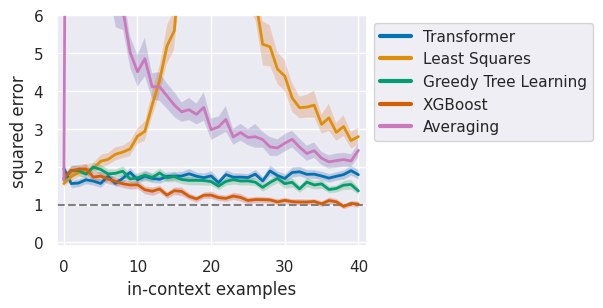

In [ ]:
metrics = collect_results(run_path, task)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
print(models)
print(metrics)
basic_plot(metrics["standard"], models=models)
plt.show()

In [ ]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue

    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)

    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

Prompting


In [ ]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [ ]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [ ]:
with torch.no_grad():
    pred = model(xs, ys)

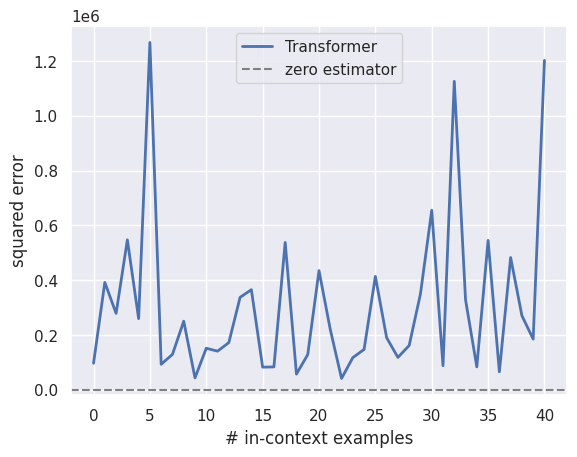

In [ ]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "single_degree_polynomial_regression": args.training.task_kwargs["degree"] if "degree" in args.training.task_kwargs else 0,
    "complex_polynomial_regression": args.training.task_kwargs["degree"] if "degree" in args.training.task_kwargs else 0
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()